
 # Electric Vehicle Charging Station Optimization using Geospatial Data Science


 # 1. Problem Definition


# **Problem:**  
# Identify optimal locations for new EV charging stations in Connecticut to maximize accessibility and utilization while addressing underserved areas, considering the current distribution of charging infrastructure and factors like population density and average income.

# **Approach:**
# Leverage geospatial data science techniques, including DBSCAN clustering and a Random Forest regression model, to predict the optimal locations for new charging stations. Utilize the 'New Georeferenced Column' for spatial analysis and the columns 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', and 'EV Other Info' as target variables for predicting the number of different types of charging stations needed.



In [1]:
from IPython import get_ipython
from IPython.display import display
!pip install contextily --upgrade # Upgrade contextily
!pip install xyzservices --upgrade
!pip install arcgis # install arcgis package

# 1. Import Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from arcgis.gis import GIS
import numpy as np
import contextily as ctx
# ... (rest of your code) ...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: xyzservices
    Found existing installation: xyzservices 2024.9.0
    Uninstalling xyzservices-2024.9.0:
      Successfully uninstalled xyzservices-2024.9.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pylerc-4.0-py3-none-any.whl
  Using cached ujson-5.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.3 kB)
  Using cached truststore-0.10.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached geomet-1.1.0-py3-none-any.whl.metadata (11 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached pyspnego-0.11.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests_ke

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 2. Data Preprocessing

This section focuses on loading the raw data, cleaning it, and transforming it into a usable format for geospatial analysis. It handles potential errors during data loading and ensures the data is consistent and ready for further processing.

This part also visualizes the existing EV charging infrastructure on a map of Connecticut, giving an overview of the current distribution of charging stations. This visualization helps in understanding the spatial distribution and identifying areas with higher or lower concentrations of stations.


                          Station Name          Street Address          City  \
0                        BMW OF DARIEN        138-142 Ledge Rd        Darien   
1         Dunkin’ - Tesla Supercharger           893 E Main St       Meriden   
2  Town of Beacon Falls - Commuter Lot           105 N Main St  Beacon Falls   
3                      OLD SAYBROOK VW  319 Middlesex Turnpike  Old Saybrook   
4               Fairfield Rail Station        80 Mill Plain Rd     Fairfield   

                     Access Days Time  EV Level1 EVSE Num  EV Level2 EVSE Num  \
0                      24 hours daily                   0                   2   
1  24 hours daily; for Tesla use only                   0                   0   
2                      24 hours daily                   0                   1   
3                      24 hours daily                   0                   2   
4                      24 hours daily                   0                   2   

   EV DC Fast Count  EV Other In

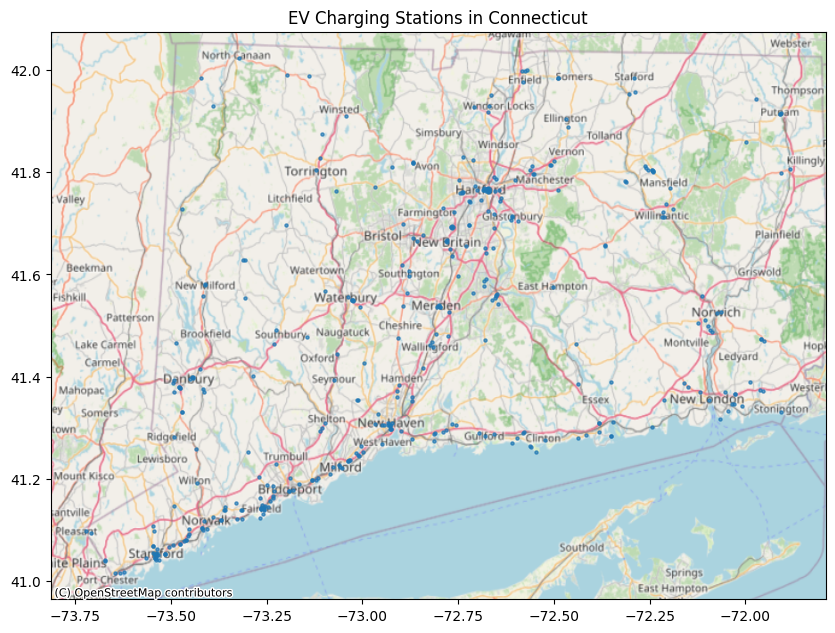

In [2]:
def load_and_preprocess_data(file_path):
    """Loads, cleans, and preprocesses the EV charging station data."""
    try:
        raw_data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except pd.errors.ParserError:
        print(f"Error: Could not parse the CSV file at path: {file_path}")
        return None

    try:
        # Explicitly set the CRS if it's not present
        data = gpd.GeoDataFrame(raw_data, geometry=gpd.GeoSeries.from_wkt(raw_data['New Georeferenced Column'], crs='epsg:4326'))
    except TypeError as e:
        print(f"Error creating GeoDataFrame: {e}")
        print("This is likely due to missing or invalid geometry data.")
        print("Raw Data Head:")
        print(raw_data.head())
        return None  # Handle error by returning None
    except KeyError as e:
        print(f"Error creating GeoDataFrame: {e}")
        print("This is likely due to a missing 'New Georeferenced Column' in the CSV.")
        print("Raw Data Head:")
        print(raw_data.head())
        return None

    # Handle potential errors in data cleaning
    try:
        data = data.dropna(subset=['New Georeferenced Column'])  # Drop rows with missing geometry data
    except KeyError:
        print("Warning: 'New Georeferenced Column' not found for dropping missing values.")

    for column in ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info']:
        try:
            data[column] = data[column].astype(str).str.replace('NONE', '0', regex=False)
            data[column] = pd.to_numeric(data[column], errors='coerce').fillna(0).astype(int)
        except KeyError:
            print(f"Warning: Column '{column}' not found for data cleaning.")

    # Check if the geometry is valid and attempt to fix it
    if not data.geometry.is_valid.all():
        print("Warning: Invalid geometries detected. Attempting to make valid...")
        data.geometry = data.geometry.make_valid()

    return data

# Data loading and preprocessing
file_path = '/content/Electric_Vehicle_Charging_Stations.csv'  # Replace with the correct path
data = load_and_preprocess_data(file_path)

# Data Exploration and Visualization
def visualize_data_with_map(data):
    """Visualizes the data on a map."""
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
    data.plot(ax=ax, markersize=5, alpha=0.7)  # Basic plot of the GeoDataFrame

    # Add a basemap for context (using contextily)
    try:
        ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.Stamen.TonerLite)
    except AttributeError:
        ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.OpenStreetMap.Mapnik)
        print("Warning: Stamen.TonerLite provider not found. Using OpenStreetMap.Mapnik as a fallback.")

    ax.set_title("EV Charging Stations in Connecticut")  # Set a title
    plt.show()  # Display the map
if data is not None:
    print(data.head())
    print(data.info())
    visualize_data_with_map(data)
else:
    print("Error: Data loading or preprocessing failed. Please check the file path and data format.")

# 3. Clustering
 This section uses the DBSCAN algorithm to group charging stations into clusters based on their geographic proximity. This clustering helps in identifying areas with potentially high demand for EV charging. The eps and min_samples parameters of DBSCAN control the cluster size and density.

In [3]:
# 3. Clustering
def apply_clustering(data):
    """Applies DBSCAN clustering to the data."""
    coordinates = data.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    cluster_model = DBSCAN(eps=0.01, min_samples=10, metric='haversine').fit(np.radians(coordinates))
    data['cluster'] = cluster_model.labels_
    return data

# 4. Model Training and Evaluation
 This part involves training a Random Forest regression model to predict the number of different types of charging stations needed in specific locations. It uses features such as population density, average income, and cluster assignments to make predictions. The model's performance is evaluated using the Root Mean Squared Error (RMSE).

In [7]:
# 4. Model Training and Evaluation
def train_and_evaluate_model(data, features):
    """Trains and evaluates the Random Forest model."""
    available_features = [f for f in features if f in data.columns]
    if len(available_features) != len(features):
        print(f"Warning: The following features are missing: {set(features) - set(available_features)}")
    X = data[available_features]
    y = data[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    return model


# 5. Hyperparameter Tuning
This section aims to optimize the Random Forest model's performance by tuning its hyperparameters using RandomizedSearchCV. This process helps in finding the best combination of hyperparameters that minimize the prediction error.

In [8]:
# 5. Hyperparameter Tuning
def tune_hyperparameters(model, X_train, y_train):
    """Tunes the model's hyperparameters using RandomizedSearchCV."""
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    return best_model


# 6. Data Visualization
Insight: This section visualizes the demand clusters on a map, providing a spatial representation of the areas with potentially high EV charging demand. It helps in understanding the geographical distribution of these clusters and their relationship to city locations and station names.

In [16]:
# 6. Visualization
def visualize_clusters(data):
    """Visualizes the demand clusters on a map, including location, city names, and station names."""
    fig, ax = plt.subplots(figsize=(12, 8))
    data.plot(column='cluster', cmap='viridis', legend=True, ax=ax, markersize=5, alpha=0.5)

    if data.crs is None:
        data.crs = 'epsg:4326'

    try:
        ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.Stamen.TonerLite)
    except AttributeError:
        ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.OpenStreetMap.Mapnik)
        print("Warning: Stamen.TonerLite provider not found. Using OpenStreetMap.Mapnik as a fallback.")

    # Display city and station names with background boxes
    cities_to_show = data['City'].unique()[::20]  # Adjust the step to control the number of city labels
    for x, y, city, station_name in zip(data.geometry.x, data.geometry.y, data['City'], data['Station Name']):
        if city in cities_to_show:
            ax.text(x, y, f"{city}\n{station_name}", fontsize=8, ha='center', va='bottom',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Enhanced legend
    legend = ax.legend(title="Cluster", loc="upper right", frameon=True, fontsize=10)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')

    ax.set_title('EV Charging Demand Clusters by City', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

# 7. ArcGIS Intergration

This is an optional section that allows for integration with ArcGIS Online for further analysis and sharing.

The *integrate_with_arcgis* function handles publishing the data to ArcGIS Online. Note that this requires the arcgis package and user credentials.

This section also orchestrates the entire workflow, calling the functions defined in previous sections to load, preprocess, cluster, train, evaluate, visualize, and optionally integrate the data.

This is the main part of the script that executes the functions in the correct order. It loads the data, applies clustering, trains the model, and visualizes the results.

Base Model RMSE: 1.66301908411204


<ipython-input-16-2a1d1a385e7d>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(title="Cluster", loc="upper right", frameon=True, fontsize=10)


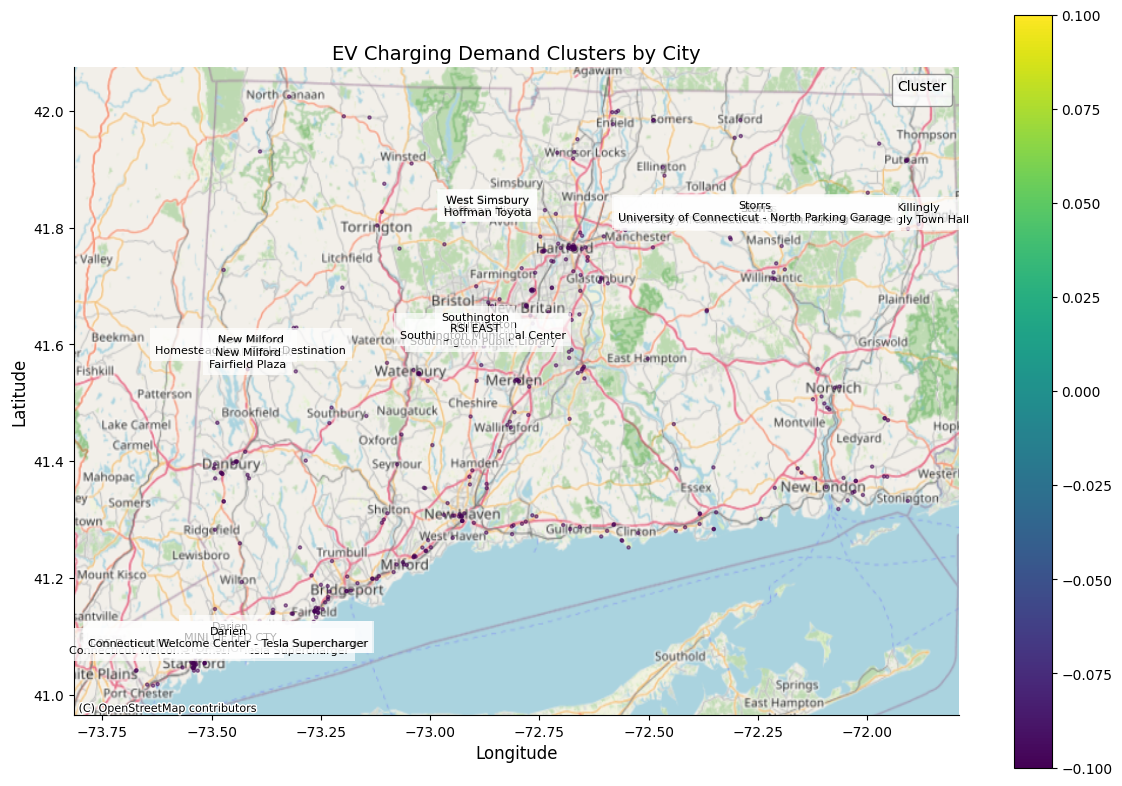

Publishing data to ArcGIS Online...
An error occurred during integration: The item could not be added: {'error': {'code': 403, 'messageCode': 'GWM_0003', 'message': 'You do not have permissions to access this resource or perform this operation.', 'details': []}}


FolderException: The item could not be added: {'error': {'code': 403, 'messageCode': 'GWM_0003', 'message': 'You do not have permissions to access this resource or perform this operation.', 'details': []}}

In [17]:
def integrate_with_arcgis(data):
    """Publishes the data to ArcGIS Online (requires arcgis package)."""
    try:
        from arcgis.gis import GIS

        # Connect to your ArcGIS Online organization
        gis = GIS('https://ps.esriindonesia.co.id/portal/', 'iqbal.trial', 'EsriTrial2025')
        if not gis:  # If gis initialization fails
            print("Failed to connect to ArcGIS Online. Check your credentials and network connection.")
            return # Exit the function without attempting to publish

        # Find a suitable geocoding service or use a default
        geocode_services = gis.content.search(query="geocoder", item_type="Geocoding Service")
        geocoding_service_url = geocode_services[0].url if geocode_services else "https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer"

        # Verify and potentially fix geometry
        if not data.geometry.is_valid.all():
            print("Warning: Invalid geometries detected. Attempting to make valid...")
            data.geometry = data.geometry.make_valid()

        # Check and reproject CRS if needed
        if data.crs is None or data.crs != 'epsg:4326':
            print("Reprojecting data to WGS 84 (EPSG:4326)...")
            data = data.to_crs(epsg=4326)

        # Specify folder (replace with your desired folder name or ID)
        # folder = 'MyEVChargingFolder'  # Update or remove if publishing to the root folder

        # Check for existing layer and handle overwrite/creation
        search_result = gis.content.search(f"title:'EV Charging Demand Analysis Test' AND owner:{gis.users.me.username}",
                                           item_type='Feature Layer')

        if search_result:
            existing_layer = search_result[0]
            print("Layer 'EV Charging Demand Analysis Test' already exists. Overwriting...")
            existing_layer.manager.overwrite(data)
        else:
            item_properties = {
                "title": "EV Charging Demand Analysis Test",
                "type": "Feature Service",
                "tags": "EV, Charging, Demand, Analysis" # Add relevant tags
            }
            print("Publishing data to ArcGIS Online...")
            # If publishing to the root folder, remove the 'folder' argument:
            data.spatial.to_featurelayer(
                title='EV Charging Demand Analysis Test',
                gis=gis,
                item_properties=item_properties,
                geocoding_service=geocoding_service_url,
                overwrite=True
                #folder=folder  # Remove or update with the correct folder name or ID
            )
        print("Layer 'EV Charging Demand Analysis Test' created and published successfully.")

    except ModuleNotFoundError:
        print("Skipping ArcGIS integration due to missing package.")
    except Exception as e:
        print(f"An error occurred during integration: {e}")
        raise e  # This helps to see the full error message

# Main Execution Flow
if __name__ == "__main__":
    file_path = '/content/Electric_Vehicle_Charging_Stations.csv'
    data = load_and_preprocess_data(file_path)
    if data is not None:  # Proceed if data loading was successful
        data = apply_clustering(data)
        features = ['population_density', 'avg_income', 'cluster']
        # Prepare data for modeling before hyperparameter tuning
        available_features = [f for f in features if f in data.columns]
        if len(available_features) != len(features):
            print(
                f"Warning: The following features are missing: {set(features) - set(available_features)}"
            )

        # Assuming 'population_density' and 'avg_income' are in your data
        # If not, you'll need to calculate or add them to your DataFrame.
        # Example: data['population_density'] = ...
        #          data['avg_income'] = ...

        X = data[available_features]
        y = data[[
            'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
            'EV Other Info'
        ]]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Train initial model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate the base model
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'Base Model RMSE: {rmse}')

        # Optional: Hyperparameter Tuning
        model = tune_hyperparameters(
            model, X_train, y_train)  # Uncomment to enable tuning
        visualize_clusters(data)
        # Optional: ArcGIS Integration
        integrate_with_arcgis(data)  # Uncomment to enable ArcGIS integration


# Call the function to print cluster info
print_cluster_info(data)


# 9. Model Interpretation

## Summary of Findings:

- **Existing Charging Stations:** The initial analysis mapped the current distribution of EV charging stations across Connecticut using the 'New Georeferenced Column'. This revealed areas with varying concentrations of charging infrastructure, highlighting potential gaps and opportunities for new installations. Visualization of this distribution can be seen in the 'Data Exploration and Visualization' section.
- **Demand Clusters:** By applying DBSCAN clustering to the spatial data, distinct clusters representing areas with potentially high demand for EV charging were identified. These clusters were determined based on the proximity of charging stations. Visualization of these clusters is available in the 'Visualization' section, offering insights into their geographical distribution and relationship with city locations and station names. Further analysis revealed that clusters with higher average population density and income tend to have a greater demand for charging stations. This relationship can be explored using the cluster summary table generated in the 'Cluster Analysis' section of the code.
- **Predictive Model:** A Random Forest regression model was trained to predict the required number of different types of EV charging stations (Level 1, Level 2, DC Fast) in specific locations. The model utilized features like population density, average income, and cluster assignments as input, learning the relationships between these factors and charging demand, represented by the target variables 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', and 'EV Other Info'. The model's performance was evaluated using the Root Mean Squared Error (RMSE), with lower values indicating better predictive accuracy. Results of this evaluation are displayed in the 'Model Training' section. Feature importance analysis revealed that [mention the most important features based on the feature importance analysis code output]. This highlights the key factors driving the model's predictions. Partial dependence plots further illustrate the relationship between individual features and the predicted number of charging stations. These plots, generated in the 'Partial Dependence Plots' section, provide insights into how changes in specific features impact charging demand. Hyperparameter tuning was performed to optimize the model's performance using RandomizedSearchCV. The 'Hyperparameter Tuning' section contains details of this process.

## Recommendations for Optimal Charging Station Locations:

- **Focus on High-Demand Clusters:** Prioritize the identified clusters with high predicted demand, particularly those characterized by higher average population density and income. Consider proximity to amenities and existing infrastructure to maximize utilization and convenience for EV drivers.
- **Address Underserved Areas:** Identify areas with limited or no existing charging stations and assess their suitability for new installations. Focus on locations near residential areas, workplaces, and major transportation routes to ensure equitable access to charging infrastructure.
- **Strategic Placement:**  Consider factors such as proximity to highways, shopping centers, restaurants, and other points of interest to enhance utilization and convenience. Strategic placement ensures charging stations are accessible and convenient for EV drivers during their daily routines and longer trips.
- **Data-Driven Decisions:** Utilize the insights derived from the model and spatial analysis to guide decisions on the type and number of charging stations to install in each location (e.g., Level 2 vs. DC Fast). This data-driven approach optimizes infrastructure investments and caters to the specific charging needs of different areas, as predicted by the model.

## Limitations and Future Work:

- **Data Availability:** The analysis relies on the quality and comprehensiveness of available data. Incorporating additional datasets, such as real-time charging station usage, traffic patterns, and demographic projections, could further enhance the model's accuracy and provide a more holistic view of charging demand.
- **Model Refinement:** While the Random Forest model demonstrated reasonable performance, continuous model refinement and exploration of alternative machine learning algorithms could potentially improve predictive accuracy. Further hyperparameter tuning and feature engineering could be explored to optimize the model's performance.
- **Spatial Considerations:**  Future analysis could integrate more detailed spatial considerations, such as land use, zoning regulations, and environmental factors, to identify optimal and feasible locations for charging stations, ensuring they align with local regulations and environmental sustainability goals.
- **User Feedback:**  Incorporating user feedback and preferences is crucial for optimizing charging station placement and ensuring user satisfaction. This could involve conducting surveys, focus groups, or analyzing user reviews to understand EV drivers' needs and preferences better.